In [1]:
import numpy as np
import scipy.io as spio
import csv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def loadMuscle():
    """
    Loading the different files and storing them in a dictionnary
    """
    
    
    HandX = spio.loadmat("dataMuscle/HandX.mat")
    HandXVel = spio.loadmat("dataMuscle/HandXVel.mat")
    HandXForce = spio.loadmat("dataMuscle/HandXForce.mat")
    
    HandY = spio.loadmat("dataMuscle/HandY.mat")
    HandYVel = spio.loadmat("dataMuscle/HandYVel.mat")
    HandYForce = spio.loadmat("dataMuscle/HandYForce.mat")
    
    Pectoralis = spio.loadmat("dataMuscle/Pectoralis.mat")
    Deltoid = spio.loadmat("dataMuscle/Deltoid.mat")
    
    extracted = spio.loadmat("dataMuscle/extracted.mat")
    descriptions = spio.loadmat("dataMuscle/descriptions.mat")
    
    
    """ 
    Creation of the first dictionnary - strMuscles
    """
    
    dictMuscles = {"HandX": HandX["HandX"],
                  "HandXVel": HandXVel["HandXVel"],
                  "HandXForce": HandXForce["HandXForce"],
                  "HandY": HandY["HandY"],
                  "HandYVel": HandYVel["HandYVel"],
                  "HandYForce": HandYForce["HandYForce"],
                  "Pectoralis": Pectoralis["Pectoralis"],
                  "Deltoid": Deltoid["Deltoid"],
                  "extracted": extracted["extracted"],
                  "descriptions": descriptions["descriptions"]}

    return dictMuscles

In [3]:
def loadNeuron():
    
    namesSignals= [
        ('time'    ),
        ('shoang'  ),
        ('elbang'  ),
        ('handxpos'),
        ('handypos'),
        ('cells'   )]
    
    dictNeurons = {}
    for targetNum in range(1,9):
            
        target = {}
            
        for trialNum in range(1,7):
            trial = {}
            for nam in namesSignals:
                key = nam
                value = spio.loadmat('dataNeuron/target'+str(targetNum)+'trial' + str(trialNum) + 'signals'+nam+'.mat')
                trial[key]=value['a']
                
            target['trial'+str(trialNum)] = trial
    
        dictNeurons['target'+str(targetNum)] = target
        
    return dictNeurons

In [4]:
def rect_kernel(t_range,width):
    """
    rect_kernel creates the rectangular kernel used to compute the firing rate

    Inputs :
    -t_range is the time span on which we want to define this kernel
    -width is the width of the rectangular kernel (in the same units as dt)

    Outputs :
    -kernel is the returned rectangular kernel
    """
    dt = t_range[1]-t_range[0]
    #print('dt: ',dt)
    n_width = int(width//dt)
    #print(n_width)
    kernel = np.zeros(len(t_range))
    centre = int(len(t_range)//2)
    for i in range(centre-int(n_width//2), centre+int(n_width//2)) :
      kernel[i] = 1/dt
    #print(len(kernel))
    return kernel

In [5]:
def firing_rate(cells,kernel):
    """
    firing rate is a function that computes the firing rate from the spike trains and a given kernel

    Inputs :
    -cells (numpy array) is the spike train we want to compute the firing rate for
    -kernel (numpy array) is the kernel used for the convolution

    Outputs :
    -firing rate (numpy array) is the resulting firing rate
    """

    firing_rate = np.convolve(cells, kernel, 'same')

    return firing_rate

In [6]:
dictMuscles = loadMuscle()
dictNeurons = loadNeuron()

FileNotFoundError: [Errno 2] No such file or directory: 'dataMuscle/HandX.mat'

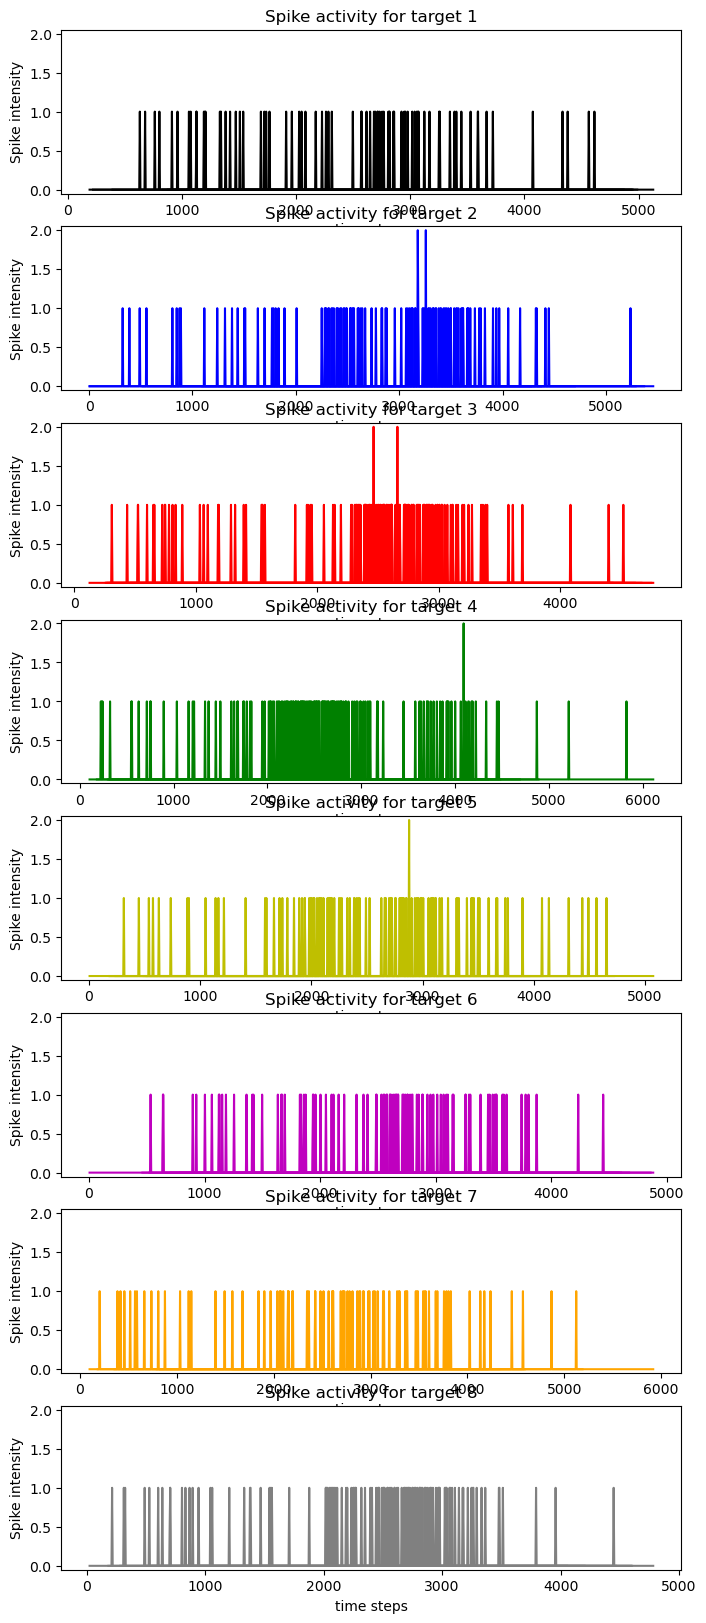

In [ ]:
# Plotting neural spikes for each trial to the first target
frequency = 200 # Hz - frequency of acquisition
T = 1/frequency # s - period of acquisition

colors = ['k','b','r','g','y','m','orange','grey']

fig, axs = plt.subplots(8, figsize=(8, 20))
for target_number in range(1,9) :
    for trial_number in range(1,7) :
        cells = dictNeurons['target'+str(target_number)]['trial'+str(trial_number)]['cells']
        # figure
        x_axis = dictNeurons['target'+str(target_number)]['trial'+str(trial_number)]['time']
        axs[target_number-1].plot(x_axis,cells,color=colors[target_number-1])
        axs[target_number-1].set_ylim([-0.05,2.05])
        axs[target_number-1].set_title('Spike activity for target '+str(target_number))
        axs[target_number-1].set_xlabel('time steps')
        axs[target_number-1].set_ylabel('Spike intensity')
plt.show()

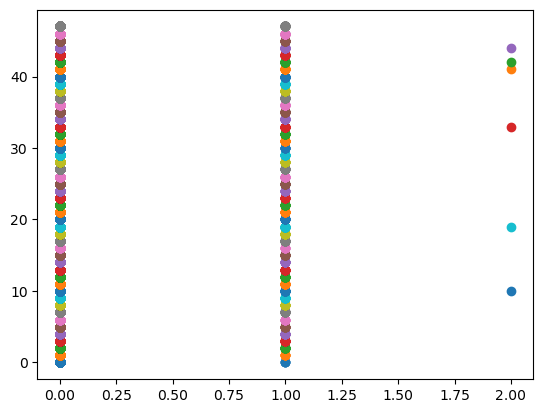

In [ ]:
# Raster plot
fig = plt.subplots()
cells_all = []
for trial_number in range(1,7) :
    for target in range(1,9) :
        cells = np.array(dictNeurons['target'+str(target)]['trial'+str(trial_number)]['cells'])
        cells_all.append(cells)

for i in range(0,len(cells_all)) :   
    plt.scatter(cells_all[i],(i)*np.ones((1,len(cells_all[i]))))
    
        
plt.show()

starting time:  0.965  seconds
ending time:  21.69  seconds
duration:  20.725  seconds


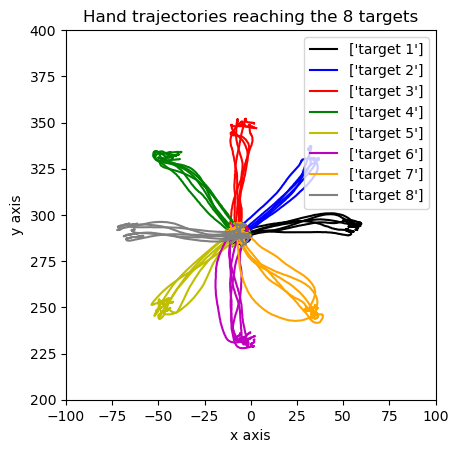

In [ ]:
#%% To find the total duration for one movement: 
#print(len(dictNeurons['target1']['trial1']['time']))
start_time = dictNeurons['target1']['trial1']['time'][0]*T
print('starting time: ', float(start_time),' seconds')
end_time = dictNeurons['target1']['trial1']['time'][-1]*T
print('ending time: ', float(end_time),' seconds')
duration = end_time-start_time
print('duration: ',float(duration),' seconds')


#%% 

# Plot hand trajectiories for each target end every trial
fig, ax = plt.subplots()
colors = ['k','b','r','g','y','m','orange','grey']
for target in range(1,9) :
    for trial_number in range(1,7) :
        handxpos = dictNeurons['target'+str(target)]['trial'+str(trial_number)]['handxpos']
        handypos = dictNeurons['target'+str(target)]['trial'+str(trial_number)]['handypos']
        # figure
        if trial_number == 1 :
            plt.plot(handxpos,handypos,color=colors[target-1],label=['target '+str(target)])
        if trial_number != 1 :
            plt.plot(handxpos,handypos,color=colors[target-1])
        ax.set_aspect('equal', 'box')
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.xlim([-100,100])
plt.ylim([200,400])
plt.legend()
plt.title('Hand trajectories reaching the 8 targets')
plt.show()

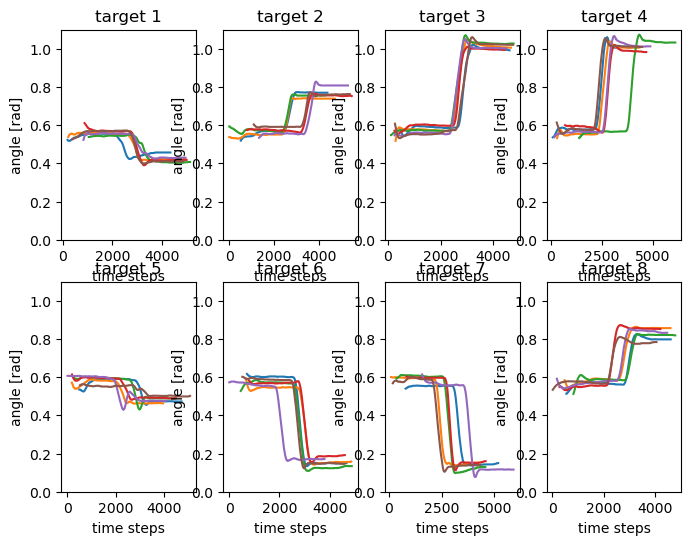

Text(0.5, 1.0, 'ZOOM - target 1 - shoulder angles')

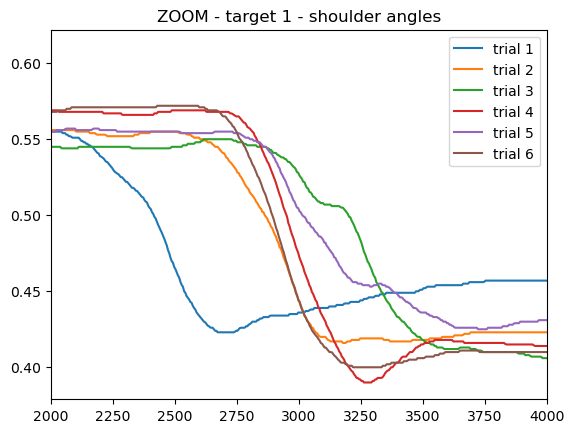

In [ ]:
# Plot shoulder angles for every trial
fig, axs = plt.subplots(2,4,figsize=(8, 6))
count = -1
for target in range(1,9) :
    count += 1
    for trial_number in range(1,7) :
        shoulder_angle = dictNeurons['target'+str(target)]['trial'+str(trial_number)]['shoang']
        time = dictNeurons['target'+str(target)]['trial'+str(trial_number)]['time']
        # figure
        axs[count//4][count%4].plot(time,shoulder_angle)
        axs[count//4][count%4].set_xlabel('time steps')
        axs[count//4][count%4].set_ylabel('angle [rad]')
        axs[count//4][count%4].set_ylim([0,1.1])
    axs[count//4][count%4].set_title('target '+str(target))
plt.show()

fig = plt.subplots()
for trial_number in range(1,7) :
    shoulder_angle = dictNeurons['target1']['trial'+str(trial_number)]['shoang']
    time = dictNeurons['target1']['trial'+str(trial_number)]['time']
    # figure
    plt.plot(time,shoulder_angle,label='trial '+str(trial_number))
    plt.xlim([2000,4000])
plt.legend()
plt.title('ZOOM - target 1 - shoulder angles')

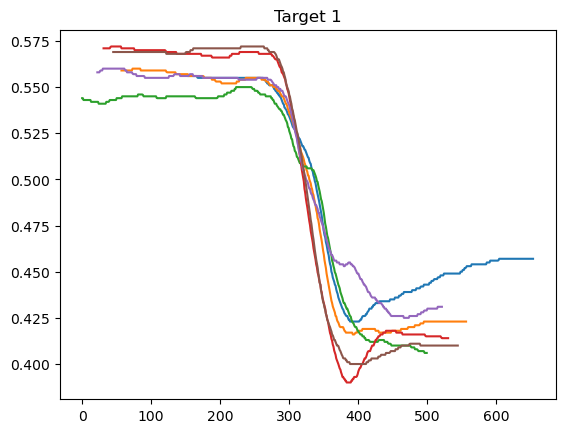

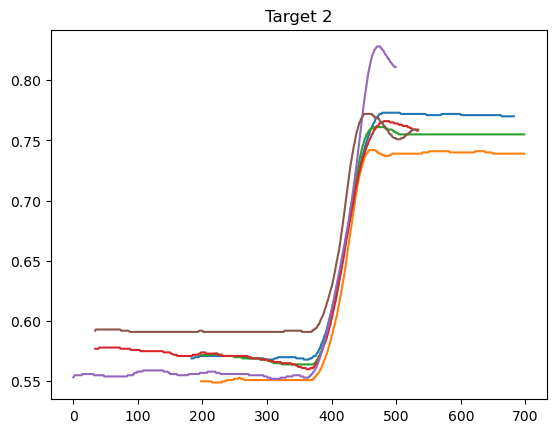

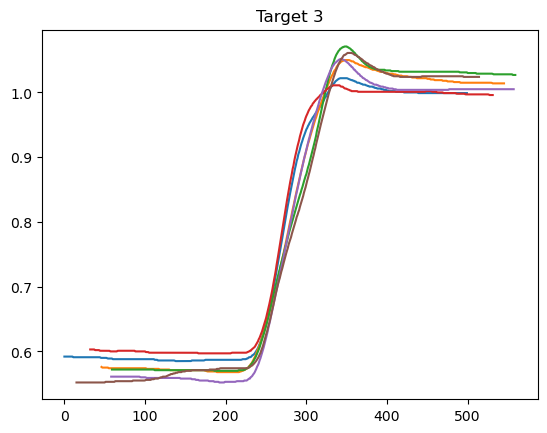

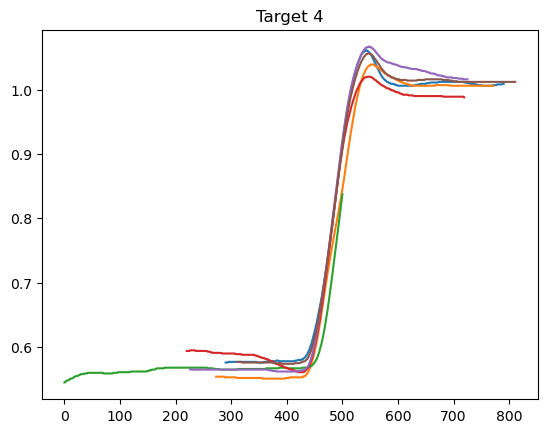

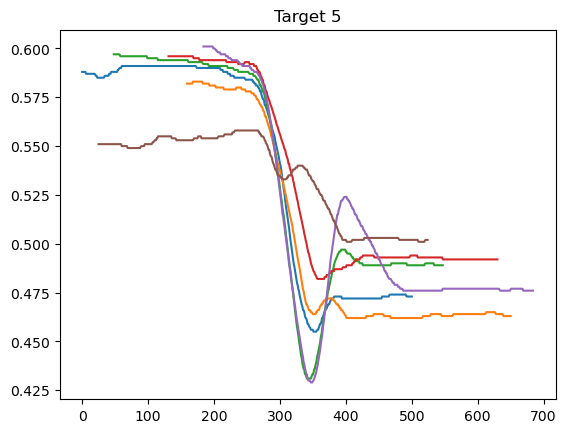

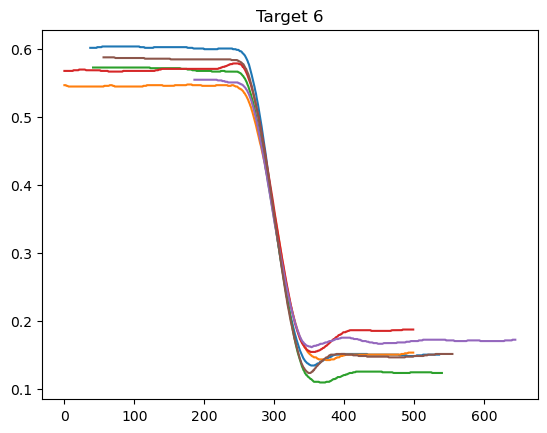

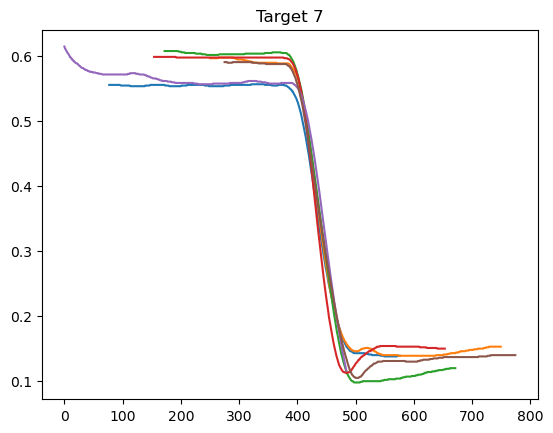

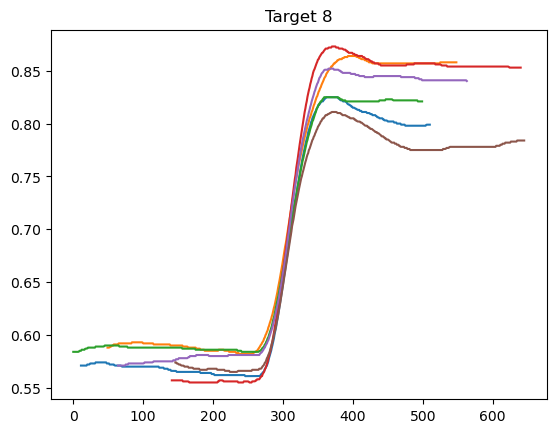

In [ ]:
# Define the threshold for determining the drop/spike
threshold = 0.2

# Define the time range you want to capture for each target
desired_start_time = 1500  # Adjust as needed
desired_end_time = 4000    # Adjust as needed

number_of_targets = 8  # Assuming there are 8 targets

shifts_mat = np.zeros((8,6))

# Iterate through each target
for target_number in range(1, number_of_targets + 1):
    target_key = 'target' + str(target_number)
    reference_points = []  # Store the reference drop/spike points

    # Find the equivalent of "2000" and "4000" for each target
    for trial_number in range(1, 7):
        time = dictNeurons[target_key]['trial' + str(trial_number)]['time']
        ind1 = np.where(time >= desired_start_time)[0][0]
        ind2 = np.where(time <= desired_end_time)[0][-1]

        shoang = dictNeurons[target_key]['trial' + str(trial_number)]['shoang']
        shoang_processed = shoang[ind1:ind2 + 1]

        # Detecting trend (increase or decrease)
        mean_initial = np.mean(shoang_processed[:10])  # First 10 points
        mean_final = np.mean(shoang_processed[-10:])  # Last 10 points

        # Determine the drop or spike point for each curve
        if mean_final < mean_initial:  # Trend is decreasing
            shoang_range = np.max(shoang_processed) - np.min(shoang_processed)
            threshold_value = np.max(shoang_processed) - threshold * shoang_range
            reference_point = np.where(shoang_processed < threshold_value)[0][0]
        else:  # Trend is increasing
            shoang_range = np.max(shoang_processed) - np.min(shoang_processed)
            threshold_value = np.min(shoang_processed) + threshold * shoang_range
            reference_point = np.where(shoang_processed > threshold_value)[0][0]

        reference_points.append(reference_point)

    # Find the reference point for this target
    reference_point = max(reference_points)

    # Create a new figure for each target
    fig, ax = plt.subplots()
    ax.set_title(f'Target {target_number}')

    # Plot each trial for this target
    for trial_number in range(1, 7):
        shoang = dictNeurons[target_key]['trial' + str(trial_number)]['shoang']
        time = dictNeurons[target_key]['trial' + str(trial_number)]['time']

        ind1 = np.where(time >= desired_start_time)[0][0]
        ind2 = np.where(time <= desired_end_time)[0][-1]
        shoang_processed = shoang[ind1:ind2 + 1]

        # Calculate the shift for the time axis
        shift = reference_point - reference_points[trial_number - 1]
        
        shifts_mat[target_number-1,trial_number-1] = shift
        
        # Apply the shift
        time_shifted = np.arange(len(shoang_processed)) + shift

        # Plot
        ax.plot(time_shifted, shoang_processed)

    plt.show()


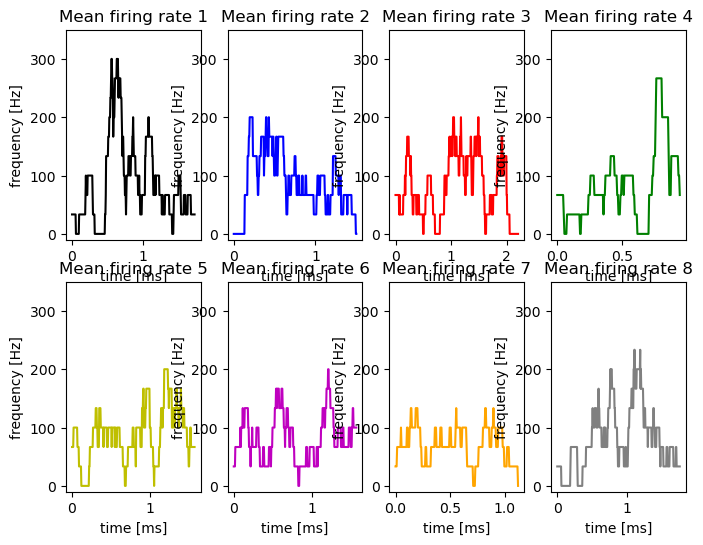

In [ ]:
colors = ['k','b','r','g','y','m','orange','grey']

fig, axs = plt.subplots(2,4,figsize=(8, 6))
count = -1
mean_firing_rates = []
for target_number in range(1,9) :
    count += 1
    
    max_shift = np.max(shifts_mat[target_number-1,:])
    firing_rates = []
    min_len = np.inf  # Initialize min_len to positive infinity

    # Find the minimum length among all cells_processed arrays
    for trial_number in range(1, 7):
        cells = np.array(dictNeurons['target1']['trial' + str(trial_number)]['cells'])
        time = dictNeurons['target1']['trial' + str(trial_number)]['time']
        ind1 = np.where(time > 1500)[0][0]
        ind2 = np.where(time > 4000)[0][0]
        cells_processed = cells[ind1:ind2]
        tot_len = len(cells_processed)
        len_processed = tot_len - int(max_shift - shifts_mat[target_number-1,trial_number-1])

        # Update min_len if necessary
        if len_processed < min_len:
            min_len = len_processed

    # Trim all cells_processed arrays to have the same minimum length
    for trial_number in range(1, 7):
        cells = np.array(dictNeurons['target1']['trial' + str(trial_number)]['cells'])
        time = dictNeurons['target1']['trial' + str(trial_number)]['time']
        ind1 = np.where(time > 1500)[0][0]
        ind2 = np.where(time > 4000)[0][0]
        cells_processed = cells[ind1:ind2]
        tot_len = len(cells_processed)
        start_idx = int(max_shift - shifts_mat[target_number-1,trial_number-1])
        end_idx = int(start_idx + min_len)
        cells_processed = cells_processed[start_idx:end_idx]

        t_range = np.arange(0, len(cells_processed) * T, T)  # maximum time duration
        kernel = rect_kernel(t_range, 100e-3)  # width = 0.1 [s] = 20 time steps
        f_rate = firing_rate(cells_processed[:,0], kernel)
        firing_rates.append(f_rate)

    firing_rates = np.array(firing_rates).reshape(6,min_len)

    # Plot the averaged firing rate
    mean_firing_rates.append(np.mean(firing_rates, 0))
    x_axis = np.arange(0,min_len*T,T)
    axs[count//4][count%4].plot(x_axis,mean_firing_rates[target_number-1],color=colors[target_number-1],label='target '+str(target_number))
    axs[count//4][count%4].set_xlabel('time [ms]')
    axs[count//4][count%4].set_ylabel('frequency [Hz]')
    axs[count//4][count%4].set_ylim([-10,350])
    axs[count//4][count%4].set_title('Mean firing rate '+str(target_number))


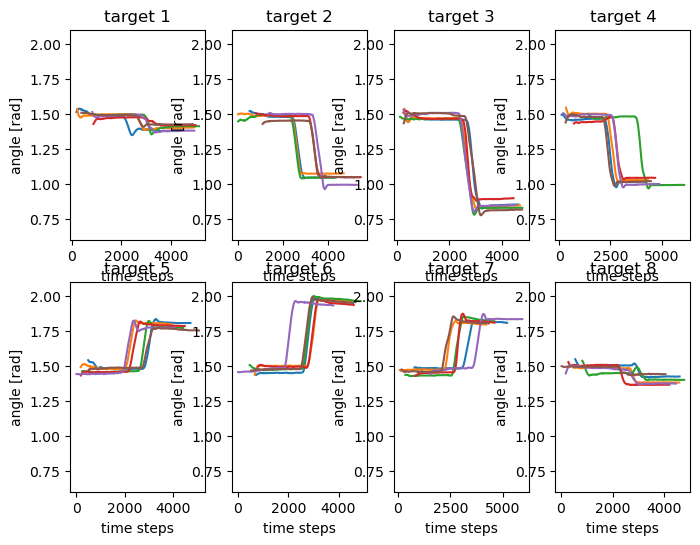

In [ ]:
# Plot elbow angles for every trial
fig, axs = plt.subplots(2,4,figsize=(8, 6))
count = -1
for target in range(1,9) :
    count += 1
    for trial_number in range(1,7) :
        elbow_angle = dictNeurons['target'+str(target)]['trial'+str(trial_number)]['elbang']
        time = dictNeurons['target'+str(target)]['trial'+str(trial_number)]['time']
        # figure
        axs[count//4][count%4].plot(time,elbow_angle)
        axs[count//4][count%4].set_xlabel('time steps')
        axs[count//4][count%4].set_ylabel('angle [rad]')
        axs[count//4][count%4].set_ylim([0.6,2.1])
    axs[count//4][count%4].set_title('target '+str(target))
plt.show()



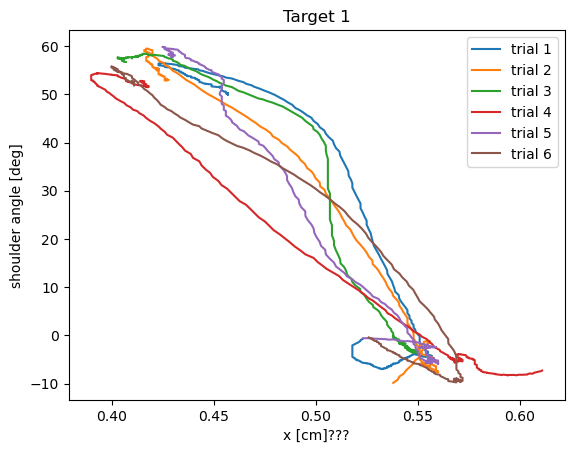

In [ ]:
#%%      
# Plot x coordinate in function of shoulder angles
# target 1
fig = plt.subplots()
for trial in range(1,7) :
    x_hand = dictNeurons['target1']['trial'+str(trial)]['handxpos']
    shoang = dictNeurons['target1']['trial'+str(trial)]['shoang']
    time = dictNeurons['target1']['trial'+str(trial)]['time']
    begins = int(t[0][0]*0.001/T)
    # Zero-padding on the spike train
    x_hand_zp = np.empty((max_length,1))
    x_hand_zp[:] = np.nan
    x_hand_zp[begins:(begins+len(x_hand))] = x_hand[:]
    shoang_zp = np.empty((max_length,1))
    shoang_zp[:] = np.nan
    shoang_zp[begins:(begins+len(shoang))] = shoang[:]
    # Plots
    plt.plot(shoang_zp,x_hand_zp,label='trial '+str(trial))
plt.title('Target 1')
plt.xlabel('x [cm]???') 
plt.ylabel('shoulder angle [deg]')
plt.legend()
plt.show()

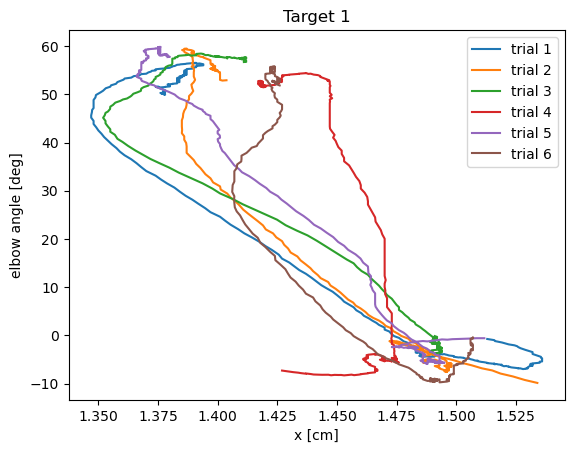

In [ ]:
# Plot x coordinate in function of elbow angles
# target 1
fig = plt.subplots()
for trial in range(1,7) :
    x_hand = dictNeurons['target1']['trial'+str(trial)]['handxpos']
    elbang = dictNeurons['target1']['trial'+str(trial)]['elbang']
    time = dictNeurons['target1']['trial'+str(trial)]['time']
    begins = int(t[0][0]*0.001/T)
    # Zero-padding on the spike train
    x_hand_zp = np.empty((max_length,1))
    x_hand_zp[:] = np.nan
    x_hand_zp[begins:(begins+len(x_hand))] = x_hand[:]
    elbang_zp = np.empty((max_length,1))
    elbang_zp[:] = np.nan
    elbang_zp[begins:(begins+len(elbang))] = elbang[:]
    # Plots
    plt.plot(elbang_zp,x_hand_zp,label='trial '+str(trial))
plt.title('Target 1')
plt.xlabel('x [cm]') 
plt.ylabel('elbow angle [deg]')
plt.legend()
plt.show()

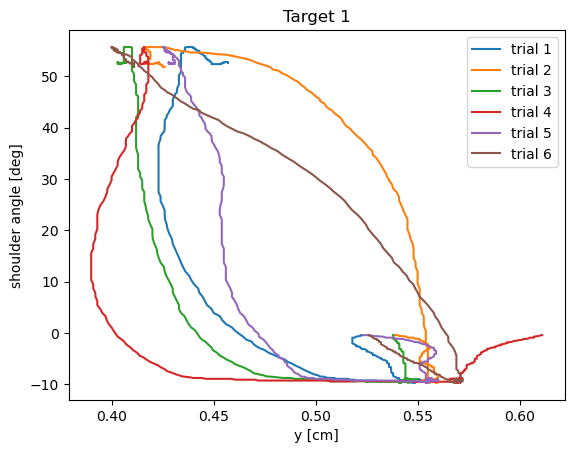

In [ ]:
# Plot y coordinate in function of shoulder angles
# target 1
fig = plt.subplots()
for trial in range(1,7) :
    y_hand = dictNeurons['target1']['trial'+str(trial)]['handypos']
    shoang = dictNeurons['target1']['trial'+str(trial)]['shoang']
    time = dictNeurons['target1']['trial'+str(trial)]['time']
    begins = int(t[0][0]*0.001/T)
    # Zero-padding on the spike train
    y_hand_zp = np.empty((max_length,1))
    y_hand_zp[:] = np.nan
    y_hand_zp[begins:(begins+len(y_hand))] = y_hand[:]
    shoang_zp = np.empty((max_length,1))
    shoang_zp[:] = np.nan
    shoang_zp[begins:(begins+len(shoang))] = shoang[:]
    # Plots
    plt.plot(shoang_zp,x_hand_zp,label='trial '+str(trial))
plt.title('Target 1')
plt.xlabel('y [cm]') 
plt.ylabel('shoulder angle [deg]')
plt.legend()
plt.show()

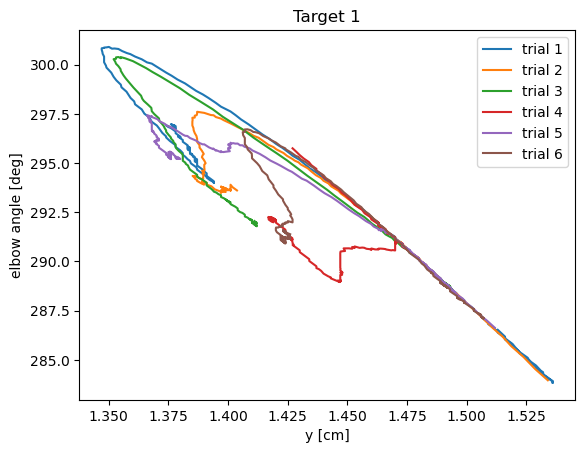

In [ ]:
# Plot y coordinate in function of elbow angles
# target 1
fig = plt.subplots()
for trial in range(1,7) :
    y_hand = dictNeurons['target1']['trial'+str(trial)]['handypos']
    elbang = dictNeurons['target1']['trial'+str(trial)]['elbang']
    time = dictNeurons['target1']['trial'+str(trial)]['time']
    begins = int(t[0][0]*0.001/T)
    # Zero-padding on the spike train
    y_hand_zp = np.empty((max_length,1))
    y_hand_zp[:] = np.nan
    y_hand_zp[begins:(begins+len(y_hand))] = y_hand[:]
    elbang_zp = np.empty((max_length,1))
    elbang_zp[:] = np.nan
    elbang_zp[begins:(begins+len(elbang))] = elbang[:]
    # Plots
    plt.plot(elbang_zp,y_hand_zp,label='trial '+str(trial))
plt.title('Target 1')
plt.xlabel('y [cm]') 
plt.ylabel('elbow angle [deg]')
plt.legend()
plt.show()